# Linear Regression 
## Tensorflow (not sklearn) to predict ~stock prices~ titanic survival
-----
Code Used: [Regression](https://www.tensorflow.org/tutorials/estimator/linear)

## Step 0: Imports and Initialization 

In [11]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [13]:
# Our dataset (it's already split into train and eval tables)
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')


## Step 1: Getting familiar with our data (EDA)

In [14]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [15]:
# Our eval set is approximately a third of the training set
(dftrain.shape[0], dfeval.shape[0])

(627, 264)

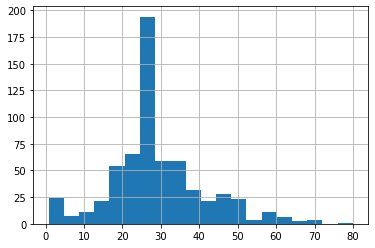

In [7]:
dftrain.age.hist(bins=20);


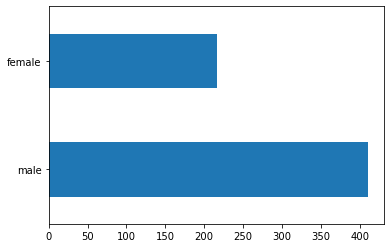

In [16]:
dftrain.sex.value_counts().plot(kind='barh');

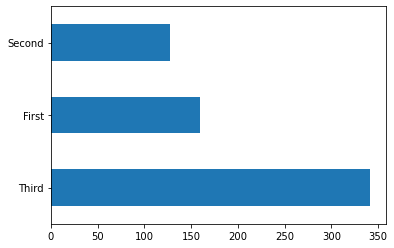

In [17]:
dftrain['class'].value_counts().plot(kind='barh');


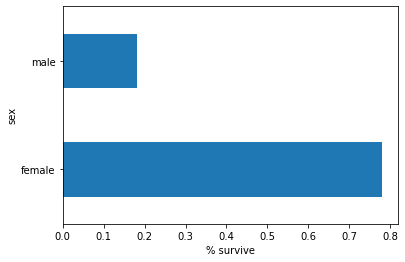

In [18]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive');

If our classifier is properly trained, we would expect a third-class female passenger in her 20s to have the highest probability of surviving.

## Step 2: Feature Engineering

Recall that regression models rely on existing features (unlike a CNN, which can "create" its own features with convolutions). This step will create some columns for our model to learn from.

For more information on how Tensorflow features work, [take a look at this Medium article](https://medium.com/ml-book/demonstration-of-tensorflow-feature-columns-tf-feature-column-3bfcca4ca5c4).

### Basic Features
These features are "built-in" to our data; they do not any additional manipulation before they are used.

Unlike sklearn, tensorflow takes care of hyperparamaters for us. All we have to do is let it know what our data looks like and convert that into a tensor.

In [22]:
# Identify the columns
feature_columns = []

# Format qual. data
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique() # set of all possible values
  # categorical_column_with_vocabulary_list one-hot encodes given a column name and a set of values
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

# Format quant. data
NUMERIC_COLUMNS = ['age', 'fare']
for feature_name in NUMERIC_COLUMNS:
  # numeric_column formats a quantitative data column into a tensor
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [23]:
# Create a tensor'd dataset from a list of feature columns + some utils
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

# The input function creates a Dataset of Datasets, each shuffled
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)


In [29]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()

# The `take` method lets us inspect a single (pseudorandom) item from our Dataset
for feature_batch, label_batch in ds.take(1):
  print('Some feature keys:', list(feature_batch.keys()))
  print('A batch of class:', feature_batch['class'].numpy())
  print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']
A batch of class: [b'First' b'First' b'Third' b'Third' b'First' b'Second' b'Third' b'First'
 b'Third' b'Third']
A batch of Labels: [1 0 0 1 1 0 0 1 0 0]


After we have loaded all our data into a Dataset, we can immediately begin training the classifier. All we have to do is load our feature columns into the `Linear Classifier` constructor.  

Note that the `train` method expects an input function which returns one of 2 things, given no parameters
1. A Dataset in the form (features, labels)
2. A tuple in the form (features, labels) where both are Tensors

Even though we shouldn't use the same eval. data, we'll train and test a classifier with our basic features to make sure everything is working correctly. Regardless of what other features we create, a linear classifier trained with derived features should have an accuracy greater than or equal to that with only basic features

In [31]:
from IPython.display import clear_output
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7537879, 'accuracy_baseline': 0.625, 'auc': 0.8332415, 'auc_precision_recall': 0.7868564, 'average_loss': 0.49916384, 'label/mean': 0.375, 'loss': 0.49416748, 'precision': 0.6440678, 'prediction/mean': 0.448505, 'recall': 0.7676768, 'global_step': 200}


### Derived Features
To get a higher accuracy, we might want to look at how columns affect each other. We can quantify these relations as columns created from functions applied of two or more columns. These types of features are called *derived features*. 

For example, we might look at the relationship between age and gender. One way we could do this is by multiplying the two columns together. 

Tensorflow provides us with a handy `crossed_column` method which takes care of this. It behaves similarly to taking the Cartesian product by hand, but conveniently bucketizes numerical data and converts categorical data into binary before multiplying.

Let's try it with our age and sex features

In [32]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7651515, 'accuracy_baseline': 0.625, 'auc': 0.84159786, 'auc_precision_recall': 0.7664438, 'average_loss': 0.47571835, 'label/mean': 0.375, 'loss': 0.46800476, 'precision': 0.6761905, 'prediction/mean': 0.3962993, 'recall': 0.7171717, 'global_step': 200}


We see (unsurprisingly) a slightly higher accuracy.

Even though our classifier will choose the best cutoff, the ROC curve might still be of some interest if we want to tune the model later.

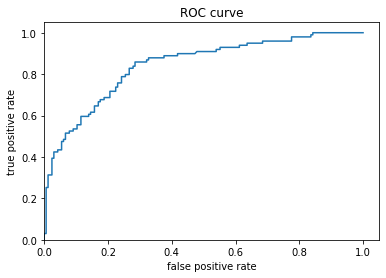

In [35]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
clear_output();
plt.show();